In [1]:
import uproot
import numpy as np
import time
from tensorflow.keras.models import load_model

import PrimaryTierFileHelper
from HigherTier import HigherTierFileHelper

In [2]:
n_events_test = 1000

In [3]:
#############################
# Let's read the file
#############################

fileName = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_0'
inputFileName = fileName + '.root'

treeFile = uproot.open(inputFileName)
tree = treeFile['ccnuselection/ccnusel']
branches = tree.arrays()

In [4]:
#############################
# Get event-level stuff
#############################
event = np.array(branches['Event'])
subrun = np.array(branches['SubRun'])
run = np.array(branches['Run'])

recoNuVertexX = np.array(branches['RecoNuVtxX'])
recoNuVertexY = np.array(branches['RecoNuVtxY'])
recoNuVertexZ = np.array(branches['RecoNuVtxZ'])
    
#############################
# Get primary link stuff 
#############################
# ID
primaryPFPIndex_main = branches['PrimaryPFPIndex']
primaryTrackShowerScore_main = branches['PrimaryTrackScore']
# link variables
primaryNSpacepoints_main = branches['PrimaryNSpacepoints']
primaryNuVertexSeparation_main = branches['PrimaryNuVertexSeparation']
primaryStartRegionNHits_main = branches['PrimaryStartRegionNHits']
primaryStartRegionNParticles_main = branches['PrimaryStartRegionNParticles']
primaryDCA_main = branches['PrimaryDCA']
primaryConnectionExtrapDistance_main = branches['PrimaryConnectionExtrapDistance']
# true
isTruePrimaryLink_main = branches['TruePrimaryLink']
isPrimaryLinkOrientationCorrect_main = branches['IsPrimaryLinkOrientationCorrect']

#############################
# Get higher tier link stuff
#############################
# ID
parentPFPIndex_main = branches['ParentPFPIndex']
childPFPIndex_main = branches['ChildPFPIndex']
trackShowerLinkType_main = branches['TrackShowerLinkType']
# link variables
parentTrackScore_main = branches['ParentTrackScore']
parentNuVertexSeparation_main = branches['ParentNuVertexSeparation']
childNuVertexSeparation_main = branches['ChildNuVertexSeparation']
parentEndRegionNHits_main = branches['ParentEndRegionNHits']
parentEndRegionNParticles_main = branches['ParentEndRegionNParticles']
parentEndRegionRToWall_main = branches['ParentEndRegionRToWall']
vertexSeparation_main = branches['VertexSeparation']
separation3D_main = branches['Separation3D']
doesChildConnect_main = branches['DoesChildConnect']
overshootStartDCA_main = branches['OvershootStartDCA']
overshootStartL_main = branches['OvershootStartL']
overshootEndDCA_main = branches['OvershootEndDCA']
overshootEndL_main = branches['OvershootEndL']
childConnectionDCA_main = branches['ChildConnectionDCA']
childConnectionExtrapDistance_main = branches['ChildConnectionExtrapDistance']
childConnectionLRatio_main = branches['ChildConnectionLRatio']
parentConnectionPointNUpstreamHits_main = branches['ParentConnectionPointNUpstreamHits']
parentConnectionPointNDownstreamHits_main = branches['ParentConnectionPointNDownstreamHits']
parentConnectionPointNHitRatio_main = branches['ParentConnectionPointNHitRatio']
parentConnectionPointEigenValueRatio_main = branches['ParentConnectionPointEigenValueRatio']
parentConnectionPointOpeningAngle_main = branches['ParentConnectionPointOpeningAngle']
pidLinkType_main = branches['PIDLinkType']
# true
trueParentChildLink_main = branches['TrueParentChildLink']
isLinkOrientationCorrect_main = branches['IsLinkOrientationCorrect']

#############################
# Get node truth
#############################
pfpTruePDG_main = branches['RecoPFPTruePDG']
trueTrackID_main = branches['RecoPFPTrueTrackID']
trueVisibleParentTrackID_main = branches['RecoPFPTrueVisibleParentTrackID']
trueVisibleGeneration_main = branches['RecoPFPTrueVisibleGeneration']
trueVisibleParentPFPIndex_main = branches['RecoPFPTrueVisibleParentPFPIndex']
nSpacepoints_main = branches['RecoPFPRecoNSpacepoints']

#############################
# Pandora metrics
#############################
trueVisibleParentSelf = branches['RecoPFPTrueVisibleParentSelf']
pandoraParentSelf_main = branches['RecoPFPRecoParentSelf']
pandoraGeneration_main = branches['RecoPFPRecoGeneration']

In [5]:
#############################
# How many entries are we working with?
#############################
nEntries = event.shape[0]
print('We are working with:', nEntries, 'entries')

We are working with: 149600 entries


In [6]:
#######################################
# Set our model file paths
#######################################

# For track primary edge classification
PRIMARY_EDGE_TRACK_IND = "/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track" # to consider all orientations (two)
PRIMARY_EDGE_TRACK_TOT = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track'        # to consider nu-track link 

# For shower primary edge classification
PRIMARY_EDGE_SHOWER_TOT = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower'      # to consider nu-shower link 

# For track-track higher tier edge classification
HIGHER_TIER_EDGE_TRACK_IND = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track'   # to consider track-track all orientations (four)
HIGHER_TIER_EDGE_TRACK_TOT = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries'          # to consider track-track link 

# For track-shower higher tier edge classification
HIGHER_TIER_EDGE_SHOWER_IND = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_shower_noPrimaries' # to consider track-shower all orientations (two)
HIGHER_TIER_EDGE_SHOWER_TOT = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_shower_noPrimaries'        # to consider track-shower link

In [7]:
############################
# Setup the models 
############################

# For track primary edge classification
primary_edge_track_ind_model = load_model(PRIMARY_EDGE_TRACK_IND)   # to consider all orientations
primary_edge_track_tot_model = load_model(PRIMARY_EDGE_TRACK_TOT)   # to consider nu-track link 

# For shower primary edge classification
primary_edge_shower_tot_model = load_model(PRIMARY_EDGE_SHOWER_TOT) # to consider nu-shower link 

# For track-track higher tier edge classification
higher_edge_track_ind_model = load_model(HIGHER_TIER_EDGE_TRACK_IND)   # to consider track-track all orientations (four)
higher_edge_track_tot_model = load_model(HIGHER_TIER_EDGE_TRACK_TOT)   # to consider track-track link 

# For track-shower higher tier edge classification
higher_edge_shower_ind_model = load_model(HIGHER_TIER_EDGE_SHOWER_IND) # to consider track-shower all orientations (two)
higher_edge_shower_tot_model = load_model(HIGHER_TIER_EDGE_SHOWER_TOT) # to consider track-shower link

In [8]:
def getIndNetworkInput_4(n_links, n_global_vars, n_link_vars, variables) :

    i_end_of_global_vars = n_global_vars
    i_target_start = variables.shape[1] - n_link_vars
    i_rest_start = n_global_vars
    i_rest_end = n_global_vars + (n_link_vars * (n_links - 1))
    
    input_0 = variables
    input_1 = np.concatenate((input_0[:,0:i_end_of_global_vars], input_0[:,i_target_start:], input_0[:,i_rest_start:i_rest_end]), axis=1)
    input_2 = np.concatenate((input_1[:,0:i_end_of_global_vars], input_1[:,i_target_start:], input_1[:,i_rest_start:i_rest_end]), axis=1)
    input_3 = np.concatenate((input_2[:,0:i_end_of_global_vars], input_2[:,i_target_start:], input_2[:,i_rest_start:i_rest_end]), axis=1)
    
    return np.concatenate((input_0, input_1, input_2, input_3), axis=0)

def getTotNetworkInput_4(y_pred, nParticleLinks) :

    y_pred_0 = y_pred[0:nParticleLinks].reshape(-1, 1, 3)
    y_pred_1 = y_pred[nParticleLinks:(nParticleLinks * 2)].reshape(-1, 1, 3)
    y_pred_2 = y_pred[(nParticleLinks * 2):(nParticleLinks * 3)].reshape(-1, 1, 3)
    y_pred_3 = y_pred[(nParticleLinks * 3):(nParticleLinks * 4)].reshape(-1, 1, 3)

    return np.concatenate((y_pred_0, y_pred_1, y_pred_2, y_pred_3), axis=1).reshape(-1, 12)

def getIndNetworkInput_2(n_links, n_global_vars, n_link_vars, variables) :

    i_end_of_global_vars = n_global_vars
    i_target_start = variables.shape[1] - n_link_vars
    i_rest_start = n_global_vars
    i_rest_end = n_global_vars + (n_link_vars * (n_links - 1))
    
    input_0 = variables
    input_1 = np.concatenate((input_0[:,0:i_end_of_global_vars], input_0[:,i_target_start:], input_0[:,i_rest_start:i_rest_end]), axis=1)

    return np.concatenate((input_0, input_1), axis=0)

def getTotNetworkInput_2(y_pred, nParticleLinks) :

    y_pred_0 = y_pred[0:nParticleLinks].reshape(-1, 1, 3)
    y_pred_1 = y_pred[nParticleLinks:(nParticleLinks * 2)].reshape(-1, 1, 3)

    return np.concatenate((y_pred_0, y_pred_1), axis=1).reshape(-1, 6)

In [9]:
time.ctime() # 'Mon Oct 18 13:35:29 2010'
time.strftime('%l:%M%p %Z on %b %d, %Y') # ' 1:36PM EDT on Oct 18, 2010'

' 3:33PM BST on Oct 10, 2024'

In [10]:
###############################################
# Get our score vectors..
###############################################

primaryPFPIndex = []
isTruePrimaryLink = []
primaryTotNetworkPred = []
primaryIsTrack = []

parentPFPIndex = []
childPFPIndex = []
isTrueParentChildLink = []
higherTotNetworkPred = []
higherIsTrack = []
higherGen = []

for iEvent in range(n_events_test) :
    
    if ((iEvent % 100) == 0) :
        print('iEvent:', str(iEvent) + '/' + str(nEntries))
    
    # For primary tier network
    primaryTierDict = {
        "primaryPFPIndex"                 : np.array(primaryPFPIndex_main[iEvent], dtype='int'), \
        "primaryTrackShowerScore"         : np.array(primaryTrackShowerScore_main[iEvent], dtype='float64'), \
        "primaryNSpacepoints"             : np.array(primaryNSpacepoints_main[iEvent], dtype='float64'), \
        "primaryNuVertexSeparation"       : np.array(primaryNuVertexSeparation_main[iEvent], dtype='float64'), \
        "primaryStartRegionNHits"         : np.array(primaryStartRegionNHits_main[iEvent], dtype='float64'), \
        "primaryStartRegionNParticles"    : np.array(primaryStartRegionNParticles_main[iEvent], dtype='float64'), \
        "primaryDCA"                      : np.array(primaryDCA_main[iEvent], dtype='float64'), \
        "primaryConnectionExtrapDistance" : np.array(primaryConnectionExtrapDistance_main[iEvent], dtype='float64'), \
        "isTruePrimaryLink"               : np.array(isTruePrimaryLink_main[iEvent], dtype='int'), \
        "isLinkOrientationCorrect"        : np.array(isPrimaryLinkOrientationCorrect_main[iEvent], dtype='int')
    }
    
    # For higher tier network
    higherTierDict = {
        "parentPFPIndex"                       : np.array(parentPFPIndex_main[iEvent], dtype='int'), \
        "childPFPIndex"                        : np.array(childPFPIndex_main[iEvent], dtype='int'), \
        "trackShowerLinkType"                  : np.array(trackShowerLinkType_main[iEvent], dtype='float64'), \
        "parentTrackScore"                     : np.array(parentTrackScore_main[iEvent], dtype='float64'), \
        "parentNuVertexSeparation"             : np.array(parentNuVertexSeparation_main[iEvent], dtype='float64'), \
        "childNuVertexSeparation"              : np.array(childNuVertexSeparation_main[iEvent], dtype='float64'), \
        "parentEndRegionNHits"                 : np.array(parentEndRegionNHits_main[iEvent], dtype='float64'), \
        "parentEndRegionNParticles"            : np.array(parentEndRegionNParticles_main[iEvent], dtype='float64'), \
        "parentEndRegionRToWall"               : np.array(parentEndRegionRToWall_main[iEvent], dtype='float64'), \
        "vertexSeparation"                     : np.array(vertexSeparation_main[iEvent], dtype='float64'), \
        "separation3D"                         : np.array(separation3D_main[iEvent], dtype='float64'), \
        "doesChildConnect"                     : np.array(doesChildConnect_main[iEvent], dtype='float64'), \
        "overshootStartDCA"                    : np.array(overshootStartDCA_main[iEvent], dtype='float64'), \
        "overshootStartL"                      : np.array(overshootStartL_main[iEvent], dtype='float64'), \
        "overshootEndDCA"                      : np.array(overshootEndDCA_main[iEvent], dtype='float64'), \
        "overshootEndL"                        : np.array(overshootEndL_main[iEvent], dtype='float64'), \
        "childConnectionDCA"                   : np.array(childConnectionDCA_main[iEvent], dtype='float64'), \
        "childConnectionExtrapDistance"        : np.array(childConnectionExtrapDistance_main[iEvent], dtype='float64'), \
        "childConnectionLRatio"                : np.array(childConnectionLRatio_main[iEvent], dtype='float64'), \
        "parentConnectionPointNUpstreamHits"   : np.array(parentConnectionPointNUpstreamHits_main[iEvent], dtype='float64'), \
        "parentConnectionPointNDownstreamHits" : np.array(parentConnectionPointNDownstreamHits_main[iEvent], dtype='float64'), \
        "parentConnectionPointNHitRatio"       : np.array(parentConnectionPointNHitRatio_main[iEvent], dtype='float64'), \
        "parentConnectionPointEigenValueRatio" : np.array(parentConnectionPointEigenValueRatio_main[iEvent], dtype='float64'), \
        "parentConnectionPointOpeningAngle"    : np.array(parentConnectionPointOpeningAngle_main[iEvent], dtype='float64'), \
        "pidLinkType"                          : np.array(pidLinkType_main[iEvent], dtype='float64'), \
        "trueParentChildLink"                  : np.array(trueParentChildLink_main[iEvent], dtype='int'), \
        "isLinkOrientationCorrect"             : np.array(isLinkOrientationCorrect_main[iEvent], dtype='int')
    }
    
    ##########################################
    # Read primary network variables
    ##########################################
    primaryPFPIndex_track, variables_track, y_track, isTruePrimaryLink_track, \
        primaryPFPIndex_shower, variables_shower, isTruePrimaryLink_shower = PrimaryTierFileHelper.readEvent(primaryTierDict)
    
    nTracks_primary = isTruePrimaryLink_track.shape[0]
    nShowers_primary = isTruePrimaryLink_shower.shape[0]
    
    if (nTracks_primary != 0) :
        indNetworkInput_track = getIndNetworkInput_2(2, 1, 5, variables_track)
        indNetworkPred_track = primary_edge_track_ind_model.predict(indNetworkInput_track, verbose=0)
        totNetworkInput_track = getTotNetworkInput_2(indNetworkPred_track, y_track.shape[0])
        totNetworkPred_track = primary_edge_track_tot_model.predict(totNetworkInput_track, verbose=0).reshape(-1)
        
#         for i in range(0, y_track.shape[0]) :
#             print('y_track:', y_track[i])
#             print('isTrueParentChildLink_track:', isTrueParentChildLink_track[i])
#             print('indNetworkPred_track:', indNetworkPred_track[i])
#             print('indNetworkPred_track:', indNetworkPred_track[i + (nTracks_higher)])
#             print('totNetworkPred_track:', totNetworkPred_track[i])
#             print('---------------')
        
    primaryPFPIndex.append(primaryPFPIndex_track if (nTracks_primary != 0) else np.empty(0))
    isTruePrimaryLink.append(isTruePrimaryLink_track if (nTracks_primary != 0) else np.empty(0))
    primaryTotNetworkPred.append(totNetworkPred_track if (nTracks_primary != 0) else np.empty(0))
    primaryIsTrack.append(np.ones(totNetworkPred_track.shape, dtype='int') if (nTracks_primary != 0) else np.empty(0))
        
    if (nShowers_primary != 0) :
        totNetworkPred_shower = primary_edge_shower_tot_model.predict(variables_shower, verbose=0).reshape(-1)
        
#         print('isTruePrimaryLink_shower:', isTruePrimaryLink_shower)
#         print('totNetworkPred_shower:', totNetworkPred_shower)
#         print('---------------')
        
    primaryPFPIndex[-1] = np.concatenate((primaryPFPIndex[-1], primaryPFPIndex_shower if (nShowers_primary != 0) else np.empty(0)))
    isTruePrimaryLink[-1] = np.concatenate((isTruePrimaryLink[-1], isTruePrimaryLink_shower if (nShowers_primary != 0) else np.empty(0)))
    primaryTotNetworkPred[-1] = np.concatenate((primaryTotNetworkPred[-1], totNetworkPred_shower if (nShowers_primary != 0) else np.empty(0)))
    primaryIsTrack[-1] = np.concatenate((primaryIsTrack[-1], np.zeros(totNetworkPred_shower.shape, dtype='int') if (nShowers_primary != 0) else np.empty(0)))
            
    ##########################################
    # Read higher tier network variables
    ##########################################   
    parentPFPIndex_track, childPFPIndex_track, variables_track, y_track, isTrueParentChildLink_track, \
        parentPFPIndex_shower, childPFPIndex_shower, variables_shower, y_shower, isTrueParentChildLink_shower = HigherTierFileHelper.readEvent(higherTierDict) 
    
    # I want to know the true generation, going to have to make this on the fly
    this_higherGen = []
    for childIndex in childPFPIndex_track :
        this_higherGen.append(trueVisibleGeneration_main[iEvent][childIndex])
        
    for childIndex in childPFPIndex_shower :
        this_higherGen.append(trueVisibleGeneration_main[iEvent][childIndex])
    
    higherGen.append(this_higherGen)
    
    nTracks_higher = isTrueParentChildLink_track.shape[0]
    nShowers_higher = isTrueParentChildLink_shower.shape[0]
    
    if (nTracks_higher != 0) :
        indNetworkInput_track = getIndNetworkInput_4(4, 6, 17, variables_track)
        indNetworkPred_track = higher_edge_track_ind_model.predict(indNetworkInput_track, verbose=0)
        totNetworkInput_track = getTotNetworkInput_4(indNetworkPred_track, y_track.shape[0])
        totNetworkPred_track = higher_edge_track_tot_model.predict(totNetworkInput_track, verbose=0).reshape(-1)
        
#         for i in range(0, y_track.shape[0]) :
#             print('y_track:', y_track[i])
#             print('isTrueParentChildLink_track:', isTrueParentChildLink_track[i])
#             print('indNetworkPred_track:', indNetworkPred_track[i])
#             print('indNetworkPred_track:', indNetworkPred_track[i + (nTracks_higher)])
#             print('indNetworkPred_track:', indNetworkPred_track[i + (nTracks_higher * 2)])
#             print('indNetworkPred_track:', indNetworkPred_track[i + (nTracks_higher * 3)])
#             print('totNetworkPred_track:', totNetworkPred_track[i])
#             print('---------------')

    parentPFPIndex.append(parentPFPIndex_track if (nTracks_higher != 0) else np.empty(0))
    childPFPIndex.append(childPFPIndex_track if (nTracks_higher != 0) else np.empty(0))
    isTrueParentChildLink.append(isTrueParentChildLink_track if (nTracks_higher != 0) else np.empty(0))
    higherTotNetworkPred.append(totNetworkPred_track if (nTracks_higher != 0) else np.empty(0))
    higherIsTrack.append(np.ones(totNetworkPred_track.shape, dtype='int') if (nTracks_higher != 0) else np.empty(0))
            
    if (nShowers_higher != 0) :
        indNetworkInput_shower = getIndNetworkInput_2(2, 6, 17, variables_shower)
        indNetworkPred_shower = higher_edge_shower_ind_model.predict(indNetworkInput_shower, verbose=0)
        totNetworkInput_shower = getTotNetworkInput_2(indNetworkPred_shower, y_shower.shape[0])
        totNetworkPred_shower = higher_edge_shower_tot_model.predict(totNetworkInput_shower, verbose=0).reshape(-1)

#         for i in range(0, y_shower.shape[0]) :
#             print('y_shower:', y_shower[i])
#             print('isTrueParentChildLink_shower:', isTrueParentChildLink_shower[i])
#             print('indNetworkPred_shower:', indNetworkPred_shower[i])
#             print('indNetworkPred_shower:', indNetworkPred_shower[i + (nShowers_higher)])
#             print('totNetworkPred_shower:', totNetworkPred_shower[i])
#             print('---------------')


    parentPFPIndex[-1] = np.concatenate((parentPFPIndex[-1], parentPFPIndex_shower if (nShowers_higher != 0) else np.empty(0)))
    childPFPIndex[-1] = np.concatenate((childPFPIndex[-1], childPFPIndex_shower if (nShowers_higher != 0) else np.empty(0)))
    isTrueParentChildLink[-1] = np.concatenate((isTrueParentChildLink[-1], isTrueParentChildLink_shower if (nShowers_higher != 0) else np.empty(0)))
    higherTotNetworkPred[-1] = np.concatenate((higherTotNetworkPred[-1], totNetworkPred_shower if (nShowers_higher != 0) else np.empty(0)))     
    higherIsTrack[-1] = np.concatenate((higherIsTrack[-1], np.zeros(totNetworkPred_shower.shape, dtype='int') if (nShowers_higher != 0) else np.empty(0)))

iEvent: 0/149600
iEvent: 100/149600
iEvent: 200/149600
iEvent: 300/149600
iEvent: 400/149600
iEvent: 500/149600
iEvent: 600/149600
iEvent: 700/149600
iEvent: 800/149600
iEvent: 900/149600


In [11]:
time.ctime() # 'Mon Oct 18 13:35:29 2010'
time.strftime('%l:%M%p %Z on %b %d, %Y') # ' 1:36PM EDT on Oct 18, 2010'

' 3:36PM BST on Oct 10, 2024'

In [12]:

# ALSO NEED TO REMOVE TRACK/SHOWER LINK TYPE FROM MODELS

print('remember!')


remember!


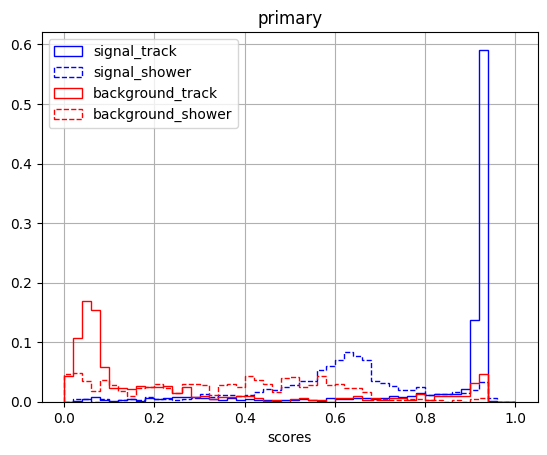

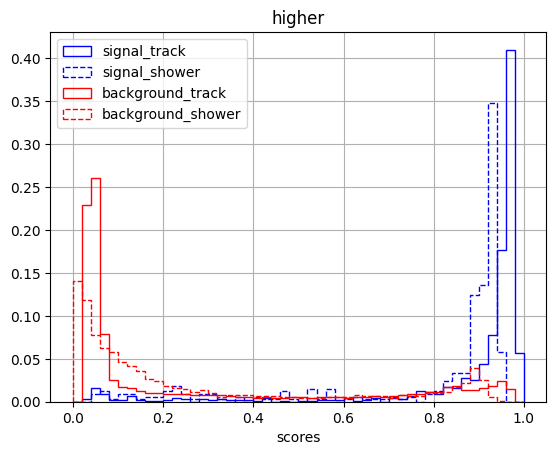

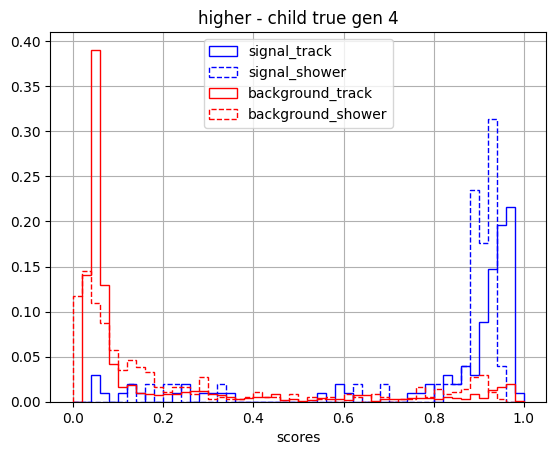

In [25]:
##############################################################
# Check that signal/background distributions are as expected
##############################################################

from matplotlib import pyplot as plt

def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

def draw(scores, truth, isTrack, graph_label, normalise) :
    
    signal_scores = np.array(flatten_comprehension(scores)).reshape(-1)
    background_scores = np.array(flatten_comprehension(scores)).reshape(-1)
    flat_truth = np.array(flatten_comprehension(truth)).reshape(-1)
    flat_is_track = np.array(flatten_comprehension(isTrack)).reshape(-1)
    
    signal_scores_track = signal_scores[np.logical_and(flat_truth == 1, flat_is_track == 1)]
    signal_scores_shower = signal_scores[np.logical_and(flat_truth == 1, flat_is_track == 0)]
    background_scores_track = background_scores[np.logical_and(flat_truth == 0, flat_is_track == 1)]
    background_scores_shower = background_scores[np.logical_and(flat_truth == 0, flat_is_track == 0)]
    
    signal_weights_track = (1.0 / float(signal_scores_track.shape[0])) if normalise else 1.0
    signal_weights_track = np.ones(signal_scores_track.shape[0]) * signal_weights_track
    signal_weights_shower = (1.0 / float(signal_scores_shower.shape[0])) if normalise else 1.0
    signal_weights_shower = np.ones(signal_scores_shower.shape[0]) * signal_weights_shower
        
    background_weights_track = (1.0 / float(background_scores_track.shape[0])) if normalise else 1.0
    background_weights_track = np.ones(background_scores_track.shape[0]) * background_weights_track  
    background_weights_shower = (1.0 / float(background_scores_shower.shape[0])) if normalise else 1.0
    background_weights_shower = np.ones(background_scores_shower.shape[0]) * background_weights_shower
    
    plt.hist(signal_scores_track, range = [0,1], bins=50, color='blue', label='signal_track', weights=signal_weights_track, fill=False, histtype='step')
    plt.hist(signal_scores_shower, range = [0,1], bins=50, color='blue', label='signal_shower', weights=signal_weights_shower, fill=False, histtype='step', linestyle='dashed')
    plt.hist(background_scores_track, range = [0,1], bins=50, color='red', label='background_track', weights=background_weights_track, fill=False, histtype='step')
    plt.hist(background_scores_shower, range = [0,1], bins=50, color='red', label='background_shower', weights=background_weights_shower, fill=False, histtype='step', linestyle='dashed')
    plt.title(graph_label)
    plt.xlabel('scores')
    plt.legend()
    plt.grid(True)
    plt.show() 
    
    
def drawGen(scores, truth, isTrack, generation, graph_label, normalise, target_gen) :
    
    signal_scores = np.array(flatten_comprehension(scores)).reshape(-1)
    background_scores = np.array(flatten_comprehension(scores)).reshape(-1)
    flat_truth = np.array(flatten_comprehension(truth)).reshape(-1)
    flat_is_track = np.array(flatten_comprehension(isTrack)).reshape(-1)
    flat_gen = np.array(flatten_comprehension(generation)).reshape(-1)
    
    signal_scores_track = signal_scores[np.logical_and(flat_truth == 1, np.logical_and(flat_is_track == 1, flat_gen == target_gen))]
    signal_scores_shower = signal_scores[np.logical_and(flat_truth == 1, np.logical_and(flat_is_track == 0, flat_gen == target_gen))]
    background_scores_track = background_scores[np.logical_and(flat_truth == 0, np.logical_and(flat_is_track == 1, flat_gen == target_gen))]
    background_scores_shower = background_scores[np.logical_and(flat_truth == 0, np.logical_and(flat_is_track == 0, flat_gen == target_gen))]
    
    signal_weights_track = (1.0 / float(signal_scores_track.shape[0])) if normalise else 1.0
    signal_weights_track = np.ones(signal_scores_track.shape[0]) * signal_weights_track
    signal_weights_shower = (1.0 / float(signal_scores_shower.shape[0])) if normalise else 1.0
    signal_weights_shower = np.ones(signal_scores_shower.shape[0]) * signal_weights_shower
        
    background_weights_track = (1.0 / float(background_scores_track.shape[0])) if normalise else 1.0
    background_weights_track = np.ones(background_scores_track.shape[0]) * background_weights_track  
    background_weights_shower = (1.0 / float(background_scores_shower.shape[0])) if normalise else 1.0
    background_weights_shower = np.ones(background_scores_shower.shape[0]) * background_weights_shower
    
    plt.hist(signal_scores_track, range = [0,1], bins=50, color='blue', label='signal_track', weights=signal_weights_track, fill=False, histtype='step')
    plt.hist(signal_scores_shower, range = [0,1], bins=50, color='blue', label='signal_shower', weights=signal_weights_shower, fill=False, histtype='step', linestyle='dashed')
    plt.hist(background_scores_track, range = [0,1], bins=50, color='red', label='background_track', weights=background_weights_track, fill=False, histtype='step')
    plt.hist(background_scores_shower, range = [0,1], bins=50, color='red', label='background_shower', weights=background_weights_shower, fill=False, histtype='step', linestyle='dashed')
    plt.title(graph_label)
    plt.xlabel('scores')
    plt.legend()
    plt.grid(True)
    plt.show() 
    
draw(primaryTotNetworkPred, isTruePrimaryLink, primaryIsTrack, 'primary', True)
draw(higherTotNetworkPred, isTrueParentChildLink, higherIsTrack, 'higher', True)

drawGen(higherTotNetworkPred, isTrueParentChildLink, higherIsTrack, higherGen, 'higher - child true gen 4', True, 4)

In [14]:
primaryPFPIndex_main = primaryPFPIndex_main[:n_events_test]
pfpTruePDG_main = pfpTruePDG_main[:n_events_test]
trueTrackID_main = trueTrackID_main[:n_events_test]
trueVisibleParentTrackID_main = trueVisibleParentTrackID_main[:n_events_test]
trueVisibleGeneration_main = trueVisibleGeneration_main[:n_events_test]
trueVisibleParentPFPIndex_main = trueVisibleParentPFPIndex_main[:n_events_test]
nSpacepoints_main = nSpacepoints_main[:n_events_test]
pandoraGeneration_main = pandoraGeneration_main[:n_events_test]
pandoraParentSelf_main = pandoraParentSelf_main[:n_events_test]
trueVisibleParentSelf = trueVisibleParentSelf[:n_events_test]

In [15]:
########################################################
# Functions to pad our vectors
########################################################

def get_max_length(input_array) :
    
    lengths = [len(entry) for entry in input_array]
    lengths = np.array(lengths)
    
    return np.max(lengths)

def create_mask(input_array, max_len):
    
    file_mask = [True] * len(input_array)
    to_fill = [False] * (max_len - len(file_mask))
    file_mask = file_mask + to_fill
    
    return file_mask

def pad_array(input_array, max_len):
    
    pad = [0] * (max_len - len(input_array))
    input_array = list(input_array) + pad
    
    return input_array

In [16]:
####################
# Create file mask
####################

# Particle node
particle_max_length = get_max_length(pfpTruePDG_main)
particle_mask_main = [create_mask(entry, particle_max_length) for entry in pfpTruePDG_main]
particle_mask_main = np.array(particle_mask_main)

print('particle_max_length:', particle_max_length)

# Primary links
primary_link_max_length = get_max_length(primaryPFPIndex)
primary_link_mask_main = [create_mask(entry, primary_link_max_length) for entry in primaryPFPIndex]
primary_link_mask_main = np.array(primary_link_mask_main)

print('primary_link_max_length:', primary_link_max_length)

# Higher links
higher_link_max_length = get_max_length(parentPFPIndex)
higher_link_mask_main = [create_mask(entry, higher_link_max_length) for entry in parentPFPIndex]
higher_link_mask_main = np.array(higher_link_mask_main)

print('primary_link_max_length:', higher_link_max_length)

particle_max_length: 32
primary_link_max_length: 31
primary_link_max_length: 720


In [17]:
##############################
# Pad vectors
##############################

#############################
# Get event-level stuff
#############################
# Don't need to pad these!

#############################
# Get node truth
#############################
trueVisibleParentSelf = [pad_array(entry, particle_max_length) for entry in trueVisibleParentSelf]
trueVisibleParentSelf = np.array(trueVisibleParentSelf)

pandoraGeneration_main = [pad_array(entry, particle_max_length) for entry in pandoraGeneration_main]
pandoraGeneration_main = np.array(pandoraGeneration_main)

pandoraParentSelf_main = [pad_array(entry, particle_max_length) for entry in pandoraParentSelf_main]
pandoraParentSelf_main = np.array(pandoraParentSelf_main)

nSpacepoints_main = [pad_array(entry, particle_max_length) for entry in nSpacepoints_main]
nSpacepoints_main = np.array(nSpacepoints_main)

trueVisibleParentPFPIndex_main = [pad_array(entry, particle_max_length) for entry in trueVisibleParentPFPIndex_main]
trueVisibleParentPFPIndex_main = np.array(trueVisibleParentPFPIndex_main)

pfpTruePDG_main = [pad_array(entry, particle_max_length) for entry in pfpTruePDG_main]
pfpTruePDG_main = np.array(pfpTruePDG_main)

trueTrackID_main = [pad_array(entry, particle_max_length) for entry in trueTrackID_main]
trueTrackID_main = np.array(trueTrackID_main)

trueVisibleParentTrackID_main = [pad_array(entry, particle_max_length) for entry in trueVisibleParentTrackID_main]
trueVisibleParentTrackID_main = np.array(trueVisibleParentTrackID_main)

trueVisibleGeneration_main = [pad_array(entry, particle_max_length) for entry in trueVisibleGeneration_main]
trueVisibleGeneration_main = np.array(trueVisibleGeneration_main)

#############################
# Get primary link stuff 
#############################
primaryPFPIndex_main = [pad_array(entry, primary_link_max_length) for entry in primaryPFPIndex]
primaryPFPIndex_main = np.array(primaryPFPIndex_main)

isTruePrimaryLink_main = [pad_array(entry, primary_link_max_length) for entry in isTruePrimaryLink]
isTruePrimaryLink_main = np.array(isTruePrimaryLink_main)

primaryTotNetworkPred_main = [pad_array(entry, primary_link_max_length) for entry in primaryTotNetworkPred]
primaryTotNetworkPred_main = np.array(primaryTotNetworkPred_main)

primaryIsTrack_main = [pad_array(entry, primary_link_max_length) for entry in primaryIsTrack]
primaryIsTrack_main = np.array(primaryIsTrack_main)

#############################
# Get higher tier link stuff
#############################
parentPFPIndex_main = [pad_array(entry, higher_link_max_length) for entry in parentPFPIndex]
parentPFPIndex_main = np.array(parentPFPIndex_main)

childPFPIndex_main = [pad_array(entry, higher_link_max_length) for entry in childPFPIndex]
childPFPIndex_main = np.array(childPFPIndex_main)

isTrueParentChildLink_main = [pad_array(entry, higher_link_max_length) for entry in isTrueParentChildLink]
isTrueParentChildLink_main = np.array(isTrueParentChildLink_main)

higherTotNetworkPred_main = [pad_array(entry, higher_link_max_length) for entry in higherTotNetworkPred]
higherTotNetworkPred_main = np.array(higherTotNetworkPred_main)

higherIsTrack_main = [pad_array(entry, higher_link_max_length) for entry in higherIsTrack]
higherIsTrack_main = np.array(higherIsTrack_main)

In [18]:
file = 'networkscores_0TEST'
outputFile = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/' + file + '.npz'
    
np.savez(outputFile, \
         event = event, \
         subrun = subrun, \
         run = run, \
         particleMask = particle_mask_main, \
         pfpTruePDG = pfpTruePDG_main, \
         trueTrackID = trueTrackID_main, \
         trueVisibleParentTrackID = trueVisibleParentTrackID_main, \
         trueVisibleGeneration = trueVisibleGeneration_main, \
         trueVisibleParentPFPIndex = trueVisibleParentPFPIndex_main, \
         nSpacepoints = nSpacepoints_main, \
         pandoraParentSelf = pandoraParentSelf_main, \
         pandoraGeneration = pandoraGeneration_main, \
         trueVisibleParentSelf = trueVisibleParentSelf, \
         primaryLinkMask = primary_link_mask_main, \
         primaryPFPIndex = primaryPFPIndex_main, \
         isTruePrimaryLink = isTruePrimaryLink_main, \
         primaryTotNetworkPred = primaryTotNetworkPred_main, \
         primaryIsTrack = primaryIsTrack_main, \
         higherLinkMask = higher_link_mask_main, \
         parentPFPIndex = parentPFPIndex_main, \
         childPFPIndex = childPFPIndex_main, \
         isTrueParentChildLink = isTrueParentChildLink_main, \
         higherTotNetworkPred = higherTotNetworkPred_main, \
         higherIsTrack = higherIsTrack_main)